In [185]:
import pandas as pd
from codecs import open
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import sys

#from __future__ import division
#from sklearn import tree

# explicitly require this experimental feature
#from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
#from sklearn.model_selection import HalvingGridSearchCV

## Read the entire collection

In [2]:
# function to read documents
def read_documents(doc_file):
    docs = []
    labels = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split(" ")
            labels.append(words[1])
            docs.append(' '.join(line.split(" ")[3:]))
    return docs, labels

In [3]:
# Read doc
all_docs, all_labels = read_documents('all_sentiment_shuffled.txt')
# Convert to DataFrame
df = pd.DataFrame({'labels': all_labels,
                          'docs': all_docs})
# Convert a collection of text documents to a matrix of token counts
# Stop words are words like “and”, “the”, “him”, which are presumed to be
# uninformative in representing the content of a text, and which may be removed
# to avoid them being construed as signal for prediction.
# https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words
vectorizer = CountVectorizer(stop_words='english')
# Learn the vocabulary dictionary and return document-term matrix
all_features = vectorizer.fit_transform(df.docs)

## Task 0: Split Data into Training and Evaluation

In [4]:
# Split arrays or matrices into random train and test subsets
# Use 80% for training and the remainder for evaluation
X_train, X_test, y_train, y_test = train_test_split(all_features, df.labels,
                                                    test_size=0.2, random_state=88)

## Task 1: Plot Distribution of # of Instances in each Class

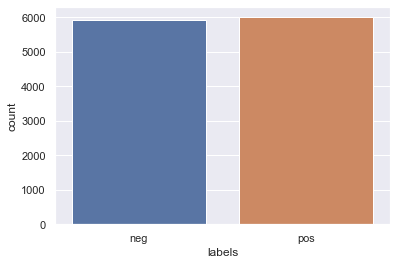

In [5]:
sns.set_theme() # Apply the default theme
sns.set_style('darkgrid') # Set Seaborn style
# Construct plot
sns.countplot(data = df, x = 'labels')
plt.show()

In [6]:
pos_len = len(df.loc[df['labels'] == 'pos'])
neg_len = len(df.loc[df['labels'] == 'neg'])
print('Number of Instances of Each Class: neg = ' + str(neg_len) + ', pos = ' + str(pos_len))

Number of Instances of Each Class: neg = 5914, pos = 6000


## Task 2: Run 3 different ML models:

### alt1) Naive Bayes Classifier (default)

In [7]:
clf_defnb = MultinomialNB()
clf_defnb.fit(X_train, y_train)
clf_y_pred_defnb = clf_defnb.predict(X_test)

#### - b) Confusion Matrix

In [8]:
conf_mtx_defnb = confusion_matrix(y_test, clf_y_pred_defnb)
print('Confusion Matrix:\n', conf_mtx_defnb)

Confusion Matrix:
 [[1001  196]
 [ 238  948]]


#### - c) Classification Report

In [9]:
clf_rep_defnb = classification_report(y_test, clf_y_pred_defnb)
print('Classification Report:\n', clf_rep_defnb)

Classification Report:
               precision    recall  f1-score   support

         neg       0.81      0.84      0.82      1197
         pos       0.83      0.80      0.81      1186

    accuracy                           0.82      2383
   macro avg       0.82      0.82      0.82      2383
weighted avg       0.82      0.82      0.82      2383



#### - d) Accuracy

In [10]:
clf_acc_defnb = accuracy_score(y_test, clf_y_pred_defnb)
print('Accuracy:', clf_acc_defnb)

Accuracy: 0.8178766261015527


### alt2) Naive Bayes Classifier (worst ~= 0 smoothing)

In [11]:
clf_badnb = MultinomialNB(alpha=0.0000000001)
clf_badnb.fit(X_train, y_train)
clf_y_pred_badnb = clf_badnb.predict(X_test)

#### - b) Confusion Matrix

In [12]:
conf_mtx_badnb = confusion_matrix(y_test, clf_y_pred_badnb)
print('Confusion Matrix:\n', conf_mtx_badnb)

Confusion Matrix:
 [[876 321]
 [347 839]]


#### - c) Classification Report

In [13]:
clf_rep_badnb = classification_report(y_test, clf_y_pred_badnb)
print('Classification Report:\n', clf_rep_badnb)

Classification Report:
               precision    recall  f1-score   support

         neg       0.72      0.73      0.72      1197
         pos       0.72      0.71      0.72      1186

    accuracy                           0.72      2383
   macro avg       0.72      0.72      0.72      2383
weighted avg       0.72      0.72      0.72      2383



#### - d) Accuracy

In [14]:
clf_acc_badnb = accuracy_score(y_test, clf_y_pred_badnb)
print('Accuracy:', clf_acc_badnb)

Accuracy: 0.7196810742761225


### a) Naive Bayes Classifier (optimal = 5 smoothing)

In [15]:
clf_optnb = MultinomialNB(alpha=5)
clf_optnb.fit(X_train, y_train)
clf_y_pred_optnb = clf_optnb.predict(X_test)

### b) Base Decision Tree

In [19]:
clf_basetree = DecisionTreeClassifier()
clf_basetree.fit(X_train, y_train)
clf_y_pred_basetree = clf_basetree.predict(X_test)

#### - c) Classification Report

In [20]:
clf_rep_basetree = classification_report(y_test, clf_y_pred_optnb)
print('Classification Report:\n', clf_rep_basetree)

Classification Report:
               precision    recall  f1-score   support

         neg       0.81      0.85      0.83      1197
         pos       0.84      0.80      0.82      1186

    accuracy                           0.82      2383
   macro avg       0.82      0.82      0.82      2383
weighted avg       0.82      0.82      0.82      2383



#### - d) Accuracy

In [21]:
clf_acc_basetree = accuracy_score(y_test, clf_y_pred_basetree)
print('Accuracy:', clf_acc_basetree)

Accuracy: 0.7230381871590432


### c) Best Decision Tree - GridSearch for Best Parameters

In [114]:
# poor params, only criterion & splitter non-defaults increase results
# criterion default=”gini”, splitter default=”best”
'''tree_param = {'criterion':['gini','entropy'],
             'splitter':['random','best'], # Best: default = ”best”
             'max_depth':range(1,10), # Best: default = None
             'min_samples_split':range(2,10), # Best: default = 2
             'min_samples_leaf':range(1,5), # Best: default = 1
             }'''

"tree_param = {'criterion':['gini','entropy'],\n             'splitter':['random','best'], # Best: default = ”best”\n             'max_depth':range(1,10), # Best: default = None\n             'min_samples_split':range(2,10), # Best: default = 2\n             'min_samples_leaf':range(1,5), # Best: default = 1\n             }"

In [142]:
tree_param = {'criterion':['gini','entropy'],
             'splitter':['random','best'],
             }

In [143]:
clf_testtree = GridSearchCV(DecisionTreeClassifier(),
                    param_grid=tree_param,
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

In [145]:
clf_testtree.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    9.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.9s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'splitter': ['random', 'best']},
             verbose=1)

In [146]:
clf_testtree.best_score_

0.7183935476025534

In [147]:
clf_testtree.best_params_

{'criterion': 'entropy', 'splitter': 'random'}

### c) Best Decision Tree

In [148]:
clf_besttree = clf_testtree.best_estimator_
clf_besttree.fit(X_train, y_train)
clf_y_pred_besttree = clf_besttree.predict(X_test)

#### - c) Classification Report

In [149]:
clf_rep_besttree = classification_report(y_test, clf_y_pred_besttree)
print('Classification Report:\n', clf_rep_besttree)

Classification Report:
               precision    recall  f1-score   support

         neg       0.72      0.75      0.73      1197
         pos       0.74      0.70      0.72      1186

    accuracy                           0.73      2383
   macro avg       0.73      0.73      0.72      2383
weighted avg       0.73      0.73      0.72      2383



#### - d) Accuracy

In [150]:
clf_acc_besttree = accuracy_score(y_test, clf_y_pred_besttree)
print('Accuracy:', clf_acc_besttree)

Accuracy: 0.7251363827108687


## Task 3: Output to Files:
#### - a) Row Number of Instance, Index of Predicted Class

In [ ]:
i = 0
for pred in clf_y_pred_optnb:
    print(str(i) + ", " + pred)
    i += 1

#### - b) Confusion Matrix

In [ ]:
conf_mtx_optnb = confusion_matrix(y_test, clf_y_pred_optnb)
print(conf_mtx_optnb)

#### - c) Classification Report

In [187]:
clf_rep_optnb = classification_report(y_test, clf_y_pred_optnb)
print(clf_rep_optnb)

              precision    recall  f1-score   support

         neg       0.81      0.85      0.83      1197
         pos       0.84      0.80      0.82      1186

    accuracy                           0.82      2383
   macro avg       0.82      0.82      0.82      2383
weighted avg       0.82      0.82      0.82      2383



In [186]:
'''def write_to_file (filename, con_mx, class_report, acc):
    with open(filename, 'w') as f:
        import sys
        # sys.stdout = f  # Change the standard output to the file we created.
        ml_model = train_model(x_train, y_train, pipeline)
        predict_eval_data(x_test, y_truth, ml_model)'''

ValueError: Expected 1D or 2D array, got 0D array instead

#### - d) Accuracy

In [152]:
clf_acc_optnb = accuracy_score(y_test, clf_y_pred_optnb)
print('Accuracy ', clf_acc_optnb, clf_y_pred_optnb)

Accuracy  0.8224926563155686 ['pos' 'pos' 'neg' ... 'neg' 'pos' 'neg']


## Task 4: Error Analysis

In [179]:

X_train_doc, X_test_doc, y_train_doc, y_test_doc = train_test_split(all_features, df.docs,
                                                    test_size=0.2, random_state=88)

In [183]:
for row_index, (doc, inpt, prediction, label) in enumerate(zip (y_test_doc, X_test, clf_y_pred_optnb, y_test)):
  if prediction != label:
    print('Row', row_index, 'has been classified as', prediction, 'and should be', label)
    print(doc)

Row 6 has been classified as neg and should be pos
jewish soles trying to avoid the devil 's brigade ( hitler 's killing machine ) .... sad , but oh so funny and cute in sections that alas , maybe only the jewish people would truly understand . i found it all of these things but with love , warmth to the end 

Row 8 has been classified as pos and should be neg
buddy holly has a number of collections that are superior to the one put out under the 20th century masters series . every one of the cds in this series is skimpy in content and superfluous . this one is no exception . look elsewhere 

Row 11 has been classified as neg and should be pos
there is a cure from your liberal disease . take a non-partisan journey with dr savage and open your so called liberal mind to the truth . and remember conservative and wacko are polar opposites 

Row 13 has been classified as neg and should be pos
i just purchased this album , my first misfits album and every song on it rocks ( i especially like 

In [ ]:
clf_optnb = MultinomialNB(alpha=5)
clf_optnb.fit(X_train, y_train)
clf_y_pred_optnb = clf_optnb.predict(X_test)
